# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pytz
import argparse
# import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase
from copy import deepcopy
import pickle as pkl
from PIL import Image
import skimage.measure
import math
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
os.environ['PYTHONWARNINGS']='ignore'
import hyperopt
from joblib import Parallel, delayed
import random
random.seed(42)
import scipy
import torch
from sklearn.model_selection import train_test_split
from scipy.interpolate import CubicSpline
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels
import gpflow

2023-08-23 19:40:19.783335: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-23 19:40:20.744171: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 19:40:22.807193: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 19:40:22.808922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 19:40:38.485804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
source = 'combined'
sensor = 'pm25'
res_time = '1H'
filepath_root = '/scratch/ab9738/pollution_with_sensors/'

# Data Loading

In [3]:
filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)
data.replace(0,np.nan,inplace=True)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

if(source=='govdata'):
    df = data_gov.unstack(level=0)
elif(source=='kaiterra'):
    df = data_kai.unstack(level=0)
else:
    df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/pollution_with_sensors/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

In [4]:
df = np.log(df)

In [5]:
locs

,UDID,Latitude,Longitude,Address,Location,Type
Monitor ID,,,,,,
BB4A,492457f434f94afc865bb4701990bb4a,28.554980,77.194430,Jamun,Hauz Khas Village,Kaiterra
91B8,ea3ceeefd9654dfd9aab41422f7391b8,28.503050,77.185660,Vihara,Chhatapur,Kaiterra
BC46,29b8262425cf4135899cd65b2458bc46,28.632950,77.288700,Segel Design,Preet Vihar,Kaiterra
BFDC,11047d2ddc514f63a12ad4f1ad3bbfdc,28.521083,77.214237,Arundhati,Saket,Kaiterra
D804,f083e8afd43e4727a5eb7f3a1529d804,28.558230,77.208620,EPoD,Yusuf Sarai,Kaiterra
...,...,...,...,...,...,...
Sirifort_CPCB,NaN,28.550425,77.215938,NaN,"Sirifort, New Delhi - CPCB",Govt
SoniaVihar_DPCC,NaN,28.710508,77.249485,NaN,"Sonia Vihar, Delhi - DPCC",Govt
SriAurobindoMarg_DPCC,NaN,28.531346,77.190156,NaN,"Sri Aurobindo Marg, Delhi - DPCC",Govt


In [20]:
mean_by_ts = df.mean(axis=1)

In [21]:
mean_by_ts

timestamp_round
2018-05-01 00:00:00+05:30    4.179304
2018-05-01 01:00:00+05:30    3.925796
2018-05-01 02:00:00+05:30    3.807353
2018-05-01 03:00:00+05:30    3.862095
2018-05-01 04:00:00+05:30    3.807360
                               ...   
2020-10-31 19:00:00+05:30    4.665083
2020-10-31 20:00:00+05:30    4.918314
2020-10-31 21:00:00+05:30    5.146825
2020-10-31 22:00:00+05:30    5.344013
2020-10-31 23:00:00+05:30    5.616525
Length: 21960, dtype: float64

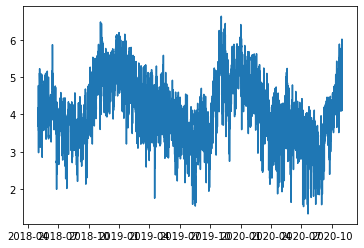

In [22]:
plt.plot(mean_by_ts)

In [23]:
mean_by_month = mean_by_ts.groupby(mean_by_ts.index.month).mean()

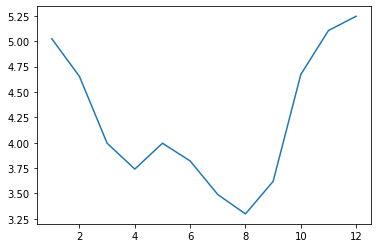

In [24]:
plt.plot(mean_by_month)

In [27]:
mean_by_date = mean_by_ts.groupby(mean_by_ts.index.day).mean()

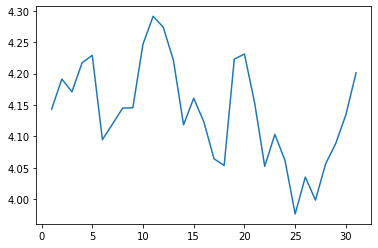

In [28]:
plt.plot(mean_by_date)

In [29]:
mean_by_day = mean_by_ts.groupby(mean_by_ts.index.day_name()).mean()

In [34]:
mean_by_day = mean_by_day.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

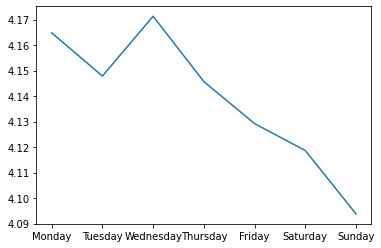

In [35]:
plt.plot(mean_by_day)

In [36]:
mean_by_year = mean_by_ts.groupby(mean_by_ts.index.year).mean()

In [37]:
mean_by_year

timestamp_round
2018    4.300534
2019    4.239226
2020    3.888642
dtype: float64